In [2]:
import pandas as pd
import numpy as np
import math
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Input Data
#### real - index: date, columns: real price of each ticker
#### pred - index: date, columns: pred price of each ticker

In [29]:
# Data loading and pre-processing
real = pd.read_csv("../prediction_data/Real_Price_All_Tickers.csv", index_col = "Date")
pred = pd.read_csv("../prediction_data/Predicted_Price_All_Tickers.csv", index_col = "Date")
real.index = pd.to_datetime(real.index)
pred.index = pd.to_datetime(pred.index)

# real dataset
real.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,128.787,474.24,157.592,167.651,317.81,78.052,557.04,156.50,97.785,97.250,...,811.19,170.262,197.536,199.15,234.64,47.248,228.83,63.929,151.08,337.71
2021-01-12,128.607,471.65,158.379,168.198,320.13,77.125,552.88,155.59,99.831,95.355,...,849.44,171.246,196.309,198.58,229.38,47.506,225.62,62.936,146.67,356.81
2021-01-13,130.694,472.05,157.772,163.821,314.33,77.432,551.14,156.44,97.875,91.780,...,854.41,170.361,196.548,199.40,227.10,48.477,229.07,64.534,141.17,364.63
2021-01-14,128.717,463.27,158.747,161.085,311.11,78.106,554.64,156.65,105.611,90.790,...,845.00,170.659,193.553,195.70,226.12,48.853,227.33,63.095,140.00,383.24
2021-01-15,126.950,458.08,157.045,160.299,308.51,79.731,567.23,156.70,102.956,88.210,...,826.16,168.155,189.700,195.27,225.55,48.457,222.56,64.485,136.60,384.53


In [30]:
# real dataset
pred.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,136.026,499.677,162.549,175.708,326.063,78.273,597.913,164.911,94.520,95.296,...,829.317,176.939,204.648,200.213,240.659,44.401,233.453,65.696,156.738,352.582
2021-01-12,133.839,500.352,164.123,173.043,323.825,77.682,597.517,164.126,97.664,98.181,...,729.419,176.905,202.220,199.112,239.311,47.752,235.197,64.649,158.885,331.353
2021-01-13,133.571,483.807,165.305,174.624,327.322,76.696,596.718,163.285,99.983,96.210,...,773.153,178.118,201.255,198.035,235.536,47.378,232.406,63.739,155.200,354.699
2021-01-14,135.152,483.404,164.823,169.509,320.109,76.991,596.648,164.069,98.214,92.141,...,862.852,177.112,201.185,199.023,233.771,49.211,235.852,64.933,146.213,366.166
2021-01-15,133.684,482.329,165.804,167.348,317.721,77.545,597.286,164.248,106.218,90.879,...,746.507,177.611,198.415,197.653,232.348,49.490,233.615,63.731,145.796,394.500


In [34]:
# global parameters
short_tol = -0.01
long_num = 30
balance = 100000.0
pct = 0.8

pred_r = pred.pct_change()
total_days = real.shape[0] - 1

In [35]:
def DivideLongShort(total, pct):
    long_budget = total * pct
    short_margin = total - long_budget
    return long_budget, short_margin

def OrderBook(budget, candidates, costs, long=True):
    orders = {ticker:0 for ticker in candidates}
    order_cost = 0
    ticker_budget = float(budget)/len(candidates)
    
    for i in range(len(candidates)):
        ticker = candidates[i]
        cost = costs[i]
        if long:
            orders[ticker] = int(ticker_budget/cost)
        else:
            orders[ticker] = int(ticker_budget/cost) * -1
        order_cost += orders[ticker] * cost
    
    return orders, order_cost

def UpdateBalance(prev_balance, long_orders, long_cost, short_orders, short_cost, real_prices):
    cur_balance = prev_balance - long_cost - short_cost
    for ticker in long_orders:
        cur_balance += long_orders[ticker] * real_prices[ticker]
    for ticker in short_orders:
        cur_balance += short_orders[ticker] * real_prices[ticker]
    return cur_balance

def DailyTrade(beg_balance, day):
    
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    short_tickers = daily_data[daily_data['pred_r'] <= short_tol]['ticker'].tolist()
    short_costs = daily_data[daily_data['pred_r'] <= short_tol]['cost'].tolist()
    long_tickers = daily_data.tail(long_num)['ticker'].tolist()
    long_costs = daily_data.tail(long_num)['cost'].tolist()

    long_budget, short_margin = DivideLongShort(beg_balance, pct)
    long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
    short_orders, short_order_cost = OrderBook(short_margin, short_tickers, short_costs, False)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                short_orders, short_order_cost, real_prices)
    
    return cur_balance

def DailyBenchmark(beg_balance, day):
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    long_tickers = daily_data['ticker'].tolist()
    long_costs = daily_data['cost'].tolist()
    long_orders, long_order_cost = OrderBook(beg_balance, long_tickers, long_costs)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, {}, 0, real_prices)
    
    return cur_balance

In [36]:
tradebal = copy.copy(balance)
bmbal = copy.copy(balance)
benchmark = []
my_portfolio = []

for day in range(total_days):
    tradebal = DailyTrade(tradebal, day)
    my_portfolio.append(tradebal)
    bmbal = DailyBenchmark(bmbal, day)
    benchmark.append(bmbal)
    
r_my = []
for x, y in zip(my_portfolio[:-1], my_portfolio[1:]):
    r_my.append((y - x) / x)
    
r_bm = []
for x, y in zip(benchmark[:-1], benchmark[1:]):
    r_bm.append((y - x) / x)
    
r_my = np.array(r_my)
r_bm = np.array(r_bm)
sharpe = (r_my.mean() - r_bm.mean()) / (r_my - r_bm).std()

print('Benchmark final: ', bmbal)
print('My Portfolio final: ', tradebal)
print('Sharpe Ratio: ', sharpe)

Benchmark final:  104516.10899999975
My Portfolio final:  95727.54200000038
Sharpe Ratio:  -0.21825027078051004


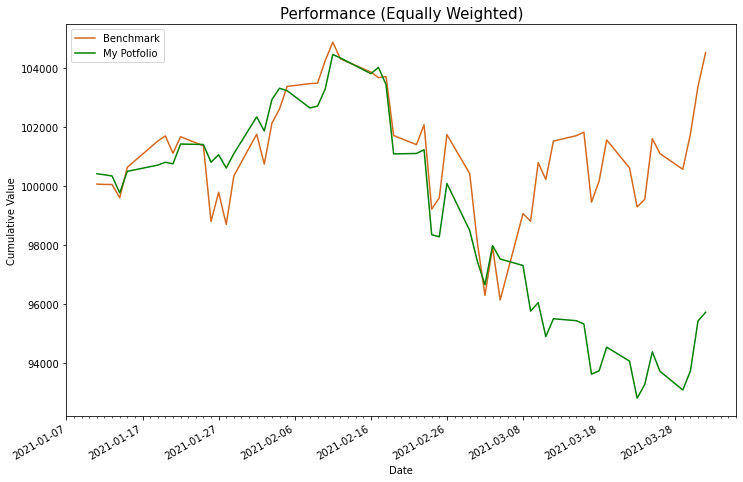

In [37]:
x = list(real.index)[:-1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)  
ax.plot(x, benchmark, '-', color="chocolate", label='Benchmark')
ax.plot(x, my_portfolio, '-', color="green", label='My Potfolio')

# set xticks
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)
fig.autofmt_xdate()

plt.legend(loc='upper left')
plt.title("Performance (Equally Weighted)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Cumulative Value")

plt.show()